In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings

warnings.filterwarnings('ignore')

### Define Pools and Algorithms

In [7]:
pools = ['Pool_49', 'Pool_52', 'Pool_60']
algorithms = ['DeepNovo', 'PEAKS', 'Novor','DirecTag']
alg_file = ['deepnovo', 'peaks', 'novor','direcTag']

RESULT_DIR = '../../../Data/Analysis_new/'

### Load the data of the experiment (all spectra), the parsed algorithm results and the scores algorithms results

In [8]:
experiment_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        raw_data =pd.read_csv(
            f"../../../Data/Datasets/{p}/Thermo_SRM_{p}_01_01_3xHCD-1h-R2-tryptic/msmsScans.txt",
            sep='\t', index_col=None)
        pool_dict[alg] = raw_data [['Scan number', 'Identified', 'Sequence']]
    experiment_data_dict[p] = pool_dict



In [9]:
parsed_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        parsed_data = pd.read_csv(f'../../../Data/ParsingResults/{p}/{file}_results_all_sequences.tsv', sep='\t', index_col=None)
        pool_dict[alg] = parsed_data
    parsed_data_dict[p] = pool_dict



In [66]:
scored_data_dict = {}

for p in pools:
    pool_dict = {}
    for alg, file in zip(algorithms, alg_file):
        file = file+'_scored'
        if file == 'direcTag_scored':
            file = file + '_grouped'
            
        identified_maxquant = pd.read_csv(f'../../../Data/ScoringResults/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_maxquant['by'] = 'MaxQuant'
        identified_inclusion_list= pd.read_csv(f'../../../Data/ScoringResults_Unidentified/CheckInclusionList/{p}/{file}.tsv', sep='\t', index_col=None, header=0)
        identified_inclusion_list['by'] = 'InclusionList'
        pool_dict[alg] = pd.concat([identified_maxquant, identified_inclusion_list], axis=0)
    scored_data_dict[p] = pool_dict

### Calculate the absolute and relative amounts of predictions/spectra

In [67]:

for alg in algorithms:
    absolute_dict = []
    relative_dict = []
    for p in pools:
        experiment_df = experiment_data_dict[p][alg]
        parsed_df = parsed_data_dict[p][alg]
        scored_df = scored_data_dict[p][alg]
        
        total = experiment_df.shape[0]
        identified_maxquant = experiment_df.query('Identified == \'+\'').shape[0]
        predicted = parsed_df.shape[0] if alg != 'DirecTag' else parsed_df['ID'].nunique()
        identified_alg = scored_df.shape[0]

        maxquant = scored_df.query('by == \'MaxQuant\'').shape[0]
        inclusion_list = scored_df.query('by == \'InclusionList\'').shape[0]
        
        absolute_dict.append([p, total, identified_maxquant, predicted, identified_alg, maxquant, inclusion_list])
        relative_dict.append([p, total/total, identified_maxquant/total, predicted/total, identified_alg/total, maxquant/total, inclusion_list/total])
    
    absolute_df = pd.DataFrame(absolute_dict, columns=['Pool','Total Spectra', 'Identified by MaxQuant', 'Predicitons made by Alg', 'Identified by Alg', 'Identified by MaxQuant', 'Identified by InclusionList'])
    relative_df = pd.DataFrame(relative_dict, columns=['Pool','Total Spectra', 'Identified by MaxQuant in %', 'Predicitons made by Alg in %', 'Identified by Alg in %', 'Identified by MaxQuant in %', 'Identified by InclusionList in %'])
    print("------------------")
    print("Algorithm: "+alg)
    print("absolute")
    print(absolute_df, '\n')
    print("average of absolute")
    print(absolute_df.drop(columns=['Pool']).mean(), '\n')
    print("relative")
    print(relative_df, '\n')
    print("average of relatives")
    print(relative_df.drop(columns=['Pool']).mean(), '\n')
    print("------------------")

print("\n\n")


------------------
Algorithm: DeepNovo
absolute
      Pool  Total Spectra  Identified by MaxQuant  Predicitons made by Alg  \
0  Pool_49          50154                   33910                    43014   
1  Pool_52          49044                   31605                    42127   
2  Pool_60          49461                   31502                    34608   

   Identified by Alg  Identified by MaxQuant  Identified by InclusionList  
0              31560                   30256                         1304  
1              30390                   27962                         2428  
2              26579                   24707                         1872   

average of absolute
Total Spectra                  49553.000000
Identified by MaxQuant         32339.000000
Predicitons made by Alg        39916.333333
Identified by Alg              29509.666667
Identified by MaxQuant         27641.666667
Identified by InclusionList     1868.000000
dtype: float64 

relative
      Pool  Total Spect

### Distribution of Identity scores shown as boxplots

DeepNovo:
      Pool  Min        Q1    Median        Q3  Max
0  Pool_49  0.0  0.357143  0.666667  0.846154  1.0
1  Pool_52  0.0  0.400000  0.700000  0.857143  1.0
2  Pool_60  0.0  0.500000  0.750000  0.888889  1.0 

PEAKS:
      Pool  Min        Q1    Median   Q3  Max
0  Pool_49  0.0  0.692308  0.857143  1.0  1.0
1  Pool_52  0.0  0.684211  0.875000  1.0  1.0
2  Pool_60  0.0  0.666667  0.875000  1.0  1.0 

Novor:
      Pool  Min        Q1    Median      Q3  Max
0  Pool_49  0.0  0.545455  0.833333  0.9375  1.0
1  Pool_52  0.0  0.571429  0.833333  1.0000  1.0
2  Pool_60  0.0  0.600000  0.842105  1.0000  1.0 

DirecTag:
      Pool  Min     Q1  Median    Q3  Max
0  Pool_49  0.0  0.475   0.625  0.75  1.0
1  Pool_52  0.0  0.425   0.575  0.75  1.0
2  Pool_60  0.0  0.450   0.600  0.75  1.0 



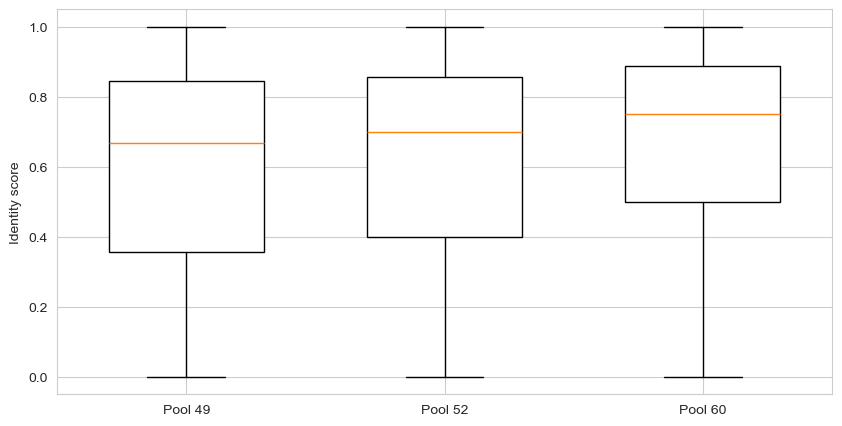

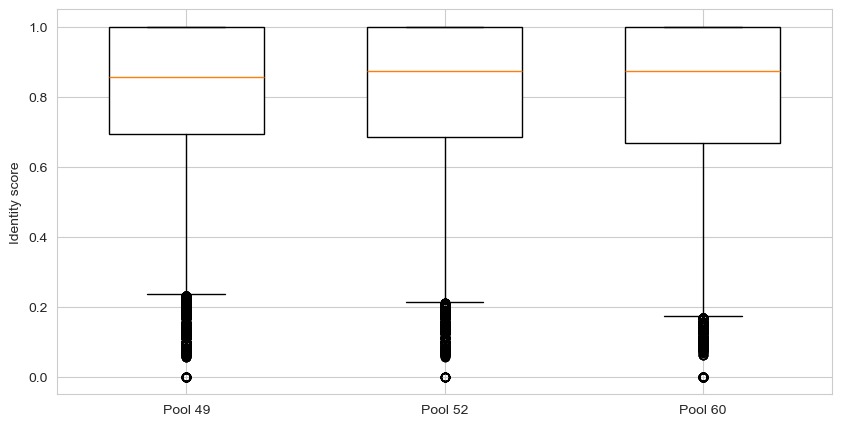

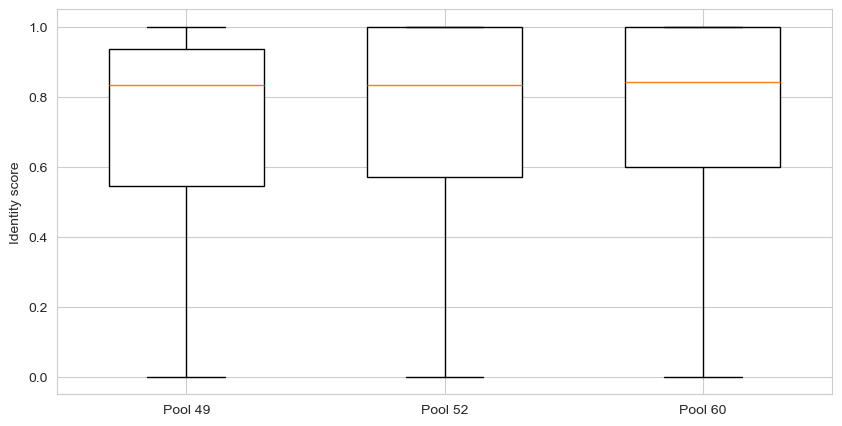

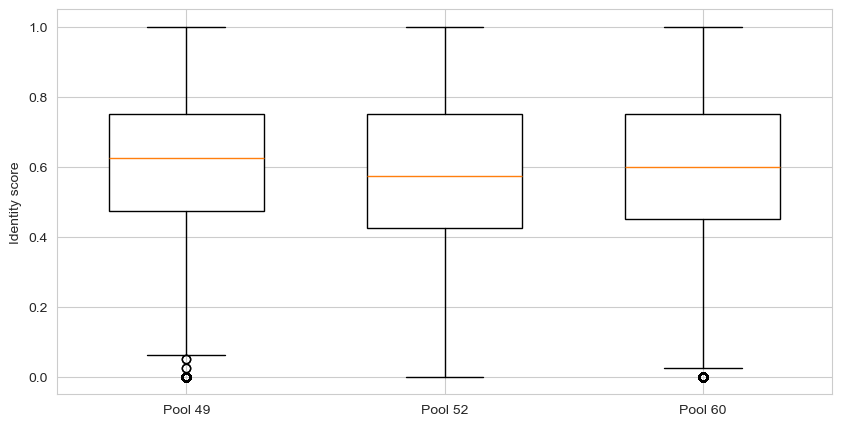

In [52]:
for alg, file in zip(algorithms, alg_file):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
    fig.set_size_inches(10, 5)
    min_dict=dict()
    median_dict=dict()
    q1_dict=dict()
    q3_dict=dict()
    max_dict=dict()
    for pool in pools:
        scored_df = scored_data_dict[pool][alg]
        # print boxplot of the identity score
        ax.boxplot(scored_df['Identity'], positions=[pools.index(pool)], widths=0.6, patch_artist=True, boxprops=dict(facecolor='white'))
        median_dict[pool] = scored_df['Identity'].median()
        q1_dict[pool] = scored_df['Identity'].quantile(0.25)
        q3_dict[pool] = scored_df['Identity'].quantile(0.75)
        max_dict[pool] = scored_df['Identity'].max()
        min_dict[pool] = scored_df['Identity'].min()
    ax.set_xticks(range(len(pools)))
    ax.set_ylabel('Identity score')
    ax.set_xticklabels([' '.join(x.split('_')) for x in pools])
    print(alg+":")
    print(pd.DataFrame({'Pool':median_dict.keys(), 'Min':min_dict.values() , 'Q1': q1_dict.values(), 'Median': median_dict.values(), 'Q3': q3_dict.values(), 'Max': max_dict.values()}), '\n')
    # fig.tight_layout()
    fig.suptitle(f'Boxplot of the Levenshtein distance score for {alg}')
    #fig.savefig(f'{RESULT_DIR}{alg}/all_pools_boxplot_levenshtein.png')

### Distribution of the Similarity scores shown as boxplots

DeepNovo:
      Pool       Min        Q1    Median   Q3  Max
0  Pool_49  0.000000  0.500000  0.818182  1.0  1.0
1  Pool_52  0.058824  0.562500  0.846154  1.0  1.0
2  Pool_60  0.000000  0.642857  1.000000  1.0  1.0 

PEAKS:
      Pool       Min        Q1  Median   Q3  Max
0  Pool_49  0.133333  0.777778     1.0  1.0  1.0
1  Pool_52  0.100000  0.777778     1.0  1.0  1.0
2  Pool_60  0.083333  0.777778     1.0  1.0  1.0 

Novor:
      Pool       Min        Q1  Median   Q3  Max
0  Pool_49  0.071429  0.666667  0.9375  1.0  1.0
1  Pool_52  0.100000  0.666667  1.0000  1.0  1.0
2  Pool_60  0.076923  0.722222  1.0000  1.0  1.0 

DirecTag:
      Pool  Min     Q1  Median   Q3  Max
0  Pool_49  0.0  0.700    0.85  1.0  1.0
1  Pool_52  0.0  0.725    0.85  1.0  1.0
2  Pool_60  0.0  0.700    0.85  1.0  1.0 



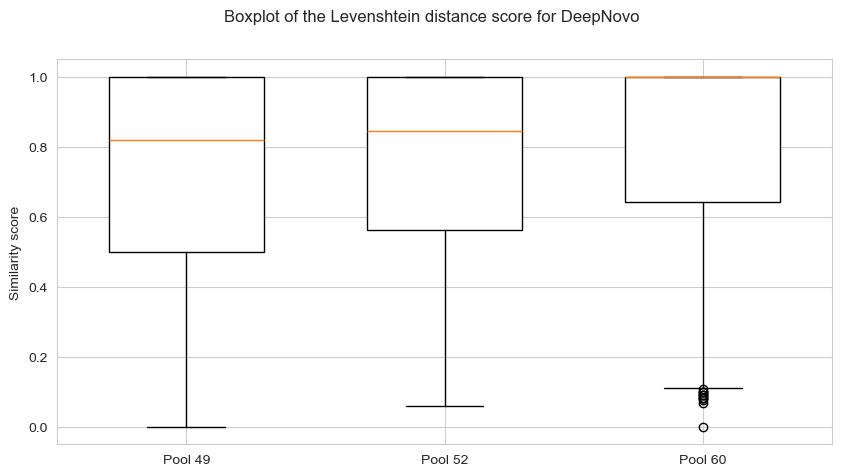

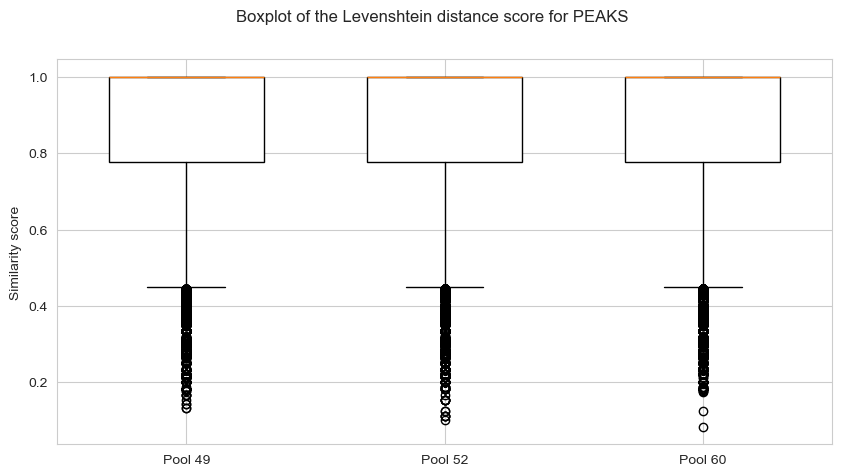

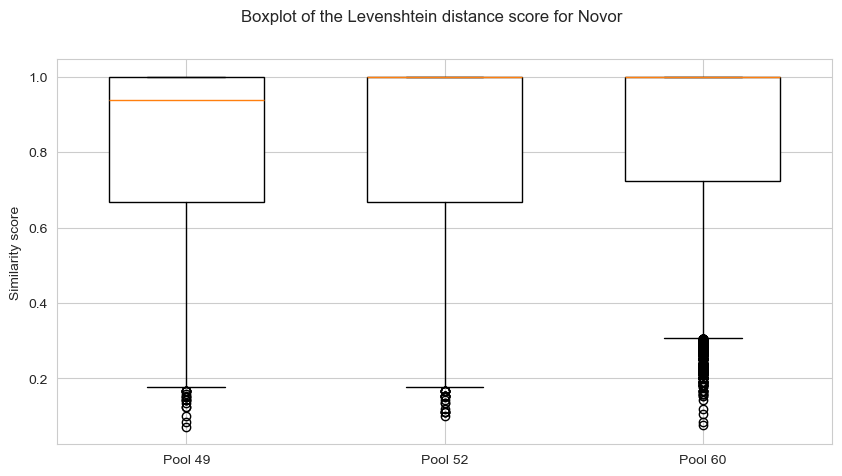

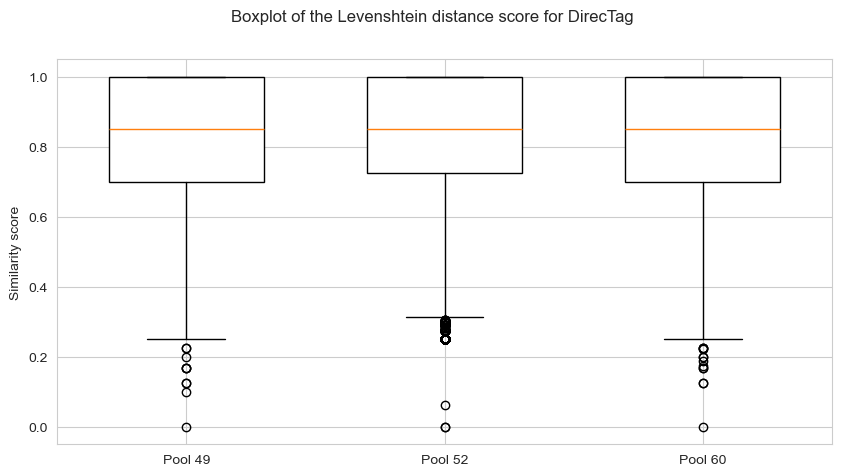

In [57]:
for alg, file in zip(algorithms, alg_file):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
    fig.set_size_inches(10, 5)
    min_dict=dict()
    median_dict=dict()
    q1_dict=dict()
    q3_dict=dict()
    max_dict=dict()
    for pool in pools:
        scored_df = scored_data_dict[pool][alg]
        # print boxplot of the Similarity score
        ax.boxplot(scored_df['Similarity'], positions=[pools.index(pool)], widths=0.6, patch_artist=True, boxprops=dict(facecolor='white'))
        median_dict[pool] = scored_df['Similarity'].median()
        q1_dict[pool] = scored_df['Similarity'].quantile(0.25)
        q3_dict[pool] = scored_df['Similarity'].quantile(0.75)
        max_dict[pool] = scored_df['Similarity'].max()
        min_dict[pool] = scored_df['Similarity'].min()
    ax.set_xticks(range(len(pools)))
    ax.set_ylabel('Similarity score')
    ax.set_xticklabels([' '.join(x.split('_')) for x in pools])
    print(alg+":")
    boxplot = pd.DataFrame({'Pool':median_dict.keys(), 'Min':min_dict.values() , 'Q1': q1_dict.values(), 'Median': median_dict.values(), 'Q3': q3_dict.values(), 'Max': max_dict.values()})
    print(boxplot, '\n')
    # fig.tight_layout()
    fig.suptitle(f'Boxplot of the Levenshtein distance score for {alg}')
    #fig.savefig(f'{RESULT_DIR}{alg}/all_pools_boxplot_levenshtein.png')

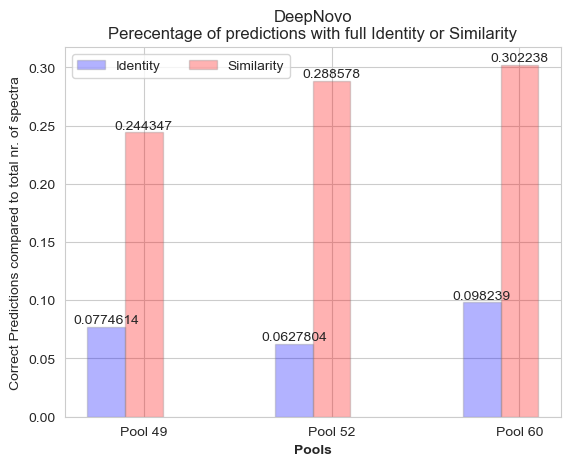

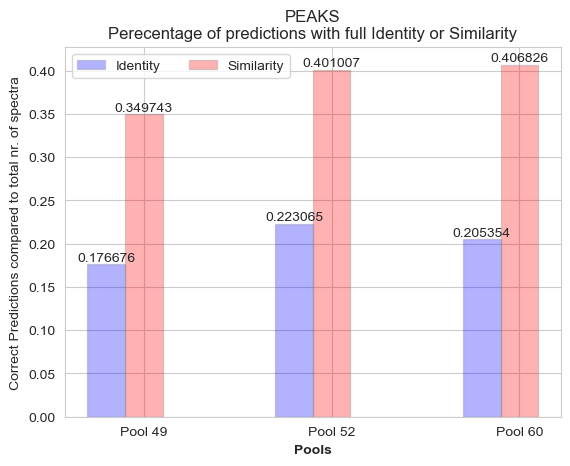

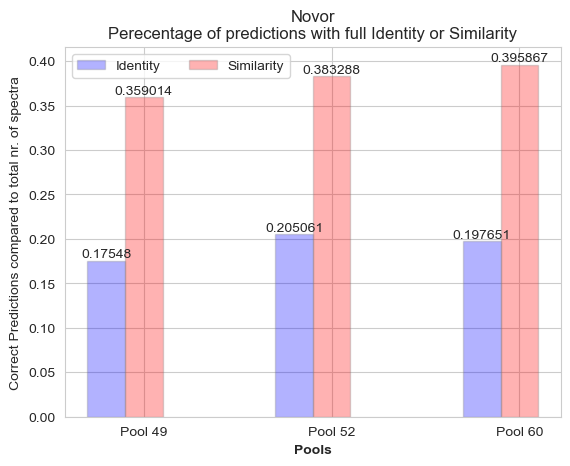

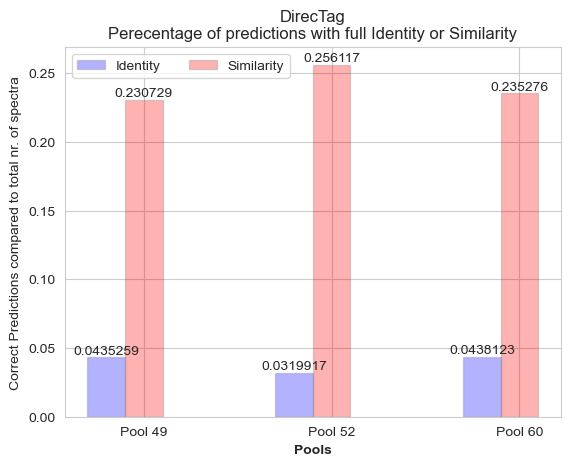

In [69]:
for alg in algorithms:
    absolute_dict = []
    relative_dict = []
    # create grouped bar plot
    fig, ax = plt.subplots()
    #plt.grid()
    barWidth = 0.2
    similarity_100_dict = {}
    identity_100_dict = {}
    
    for i, p in enumerate(pools):
        experiment_df = experiment_data_dict[p][alg]
        parsed_df = parsed_data_dict[p][alg]
        scored_df = scored_data_dict[p][alg]
        # create bar plot
        
        total = experiment_df.shape[0]
        identified_maxquant = experiment_df.query('Identified == \'+\'').shape[0]
        predicted = parsed_df.shape[0] if alg != 'DirecTag' else parsed_df['ID'].nunique()
        identified_alg = scored_df.shape[0]

        similarity_100_dict[p] = scored_df.query('Similarity == 1.0').shape[0]/total
        identity_100_dict[p] = scored_df.query('Identity == 1.0').shape[0]/total

    bars1_1 = [identity_100_dict[p] for p in pools]
    bars2 = [similarity_100_dict[p] for p in pools]
    
    # create bar plot
    plt.title(f'{alg}\nPerecentage of predictions with full Identity or Similarity')
    barWidth = 0.2
    r1 = range(len(bars1_1))
    r2 = [x + barWidth for x in r1]
    plt.bar_label(plt.bar(r1, bars1_1, color='b', width=barWidth, edgecolor='grey', label='Identity', alpha=0.3))
    plt.bar_label(plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Similarity', alpha=0.3))
    plt.xlabel('Pools', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1_1))], [' '.join(x.split('_')) for x in pools])
    plt.legend(loc='best', ncols=2)
    plt.ylabel('Correct Predictions compared to total nr. of spectra')
    plt.savefig(f'{RESULT_DIR}{alg}/perfect_pred_compared_to_nr_of_pred.png')
    plt.show()
    
        

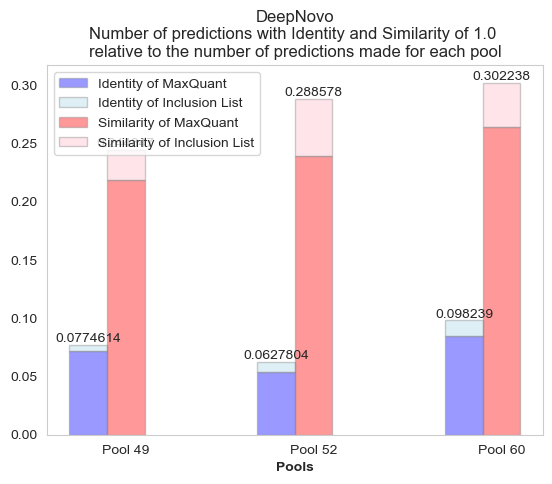

DeepNovo :
identity:
 {'MaxQuant': [0.0715595964429557, 0.05417584210097056, 0.0846323365884232], 'InclusionList': [0.005901822387047892, 0.008604518391648316, 0.013606680010513334]}
similarity:
 {'MaxQuant': [0.2183474897316266, 0.2390710382513661, 0.26439012555346636], 'InclusionList': [0.025999920245643418, 0.049506565532990786, 0.037848001455692365]}




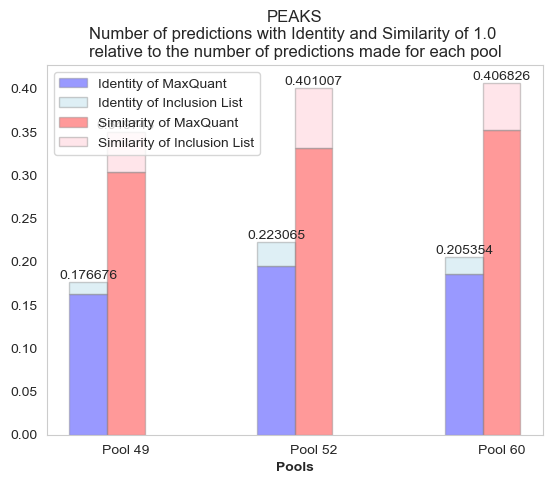

PEAKS :
identity:
 {'MaxQuant': [0.16261913307014395, 0.19482505505260583, 0.1858838276621985], 'InclusionList': [0.014056705347529608, 0.02823994780197374, 0.01946988536422636]}
similarity:
 {'MaxQuant': [0.3037644056306576, 0.33149824647255527, 0.3521562443137017], 'InclusionList': [0.04597838656936635, 0.06950901231547182, 0.05466933543600008]}




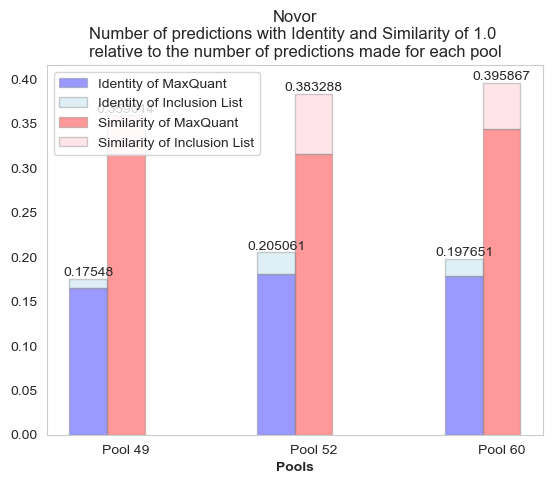

Novor :
identity:
 {'MaxQuant': [0.16449336044981458, 0.1804094282684936, 0.17805948120741594], 'InclusionList': [0.01098616261913307, 0.024651333496452165, 0.019591193061199733]}
similarity:
 {'MaxQuant': [0.3152689715675719, 0.31524753282766493, 0.34427124401043246], 'InclusionList': [0.04374526458507796, 0.06804094282684936, 0.05159620711267463]}




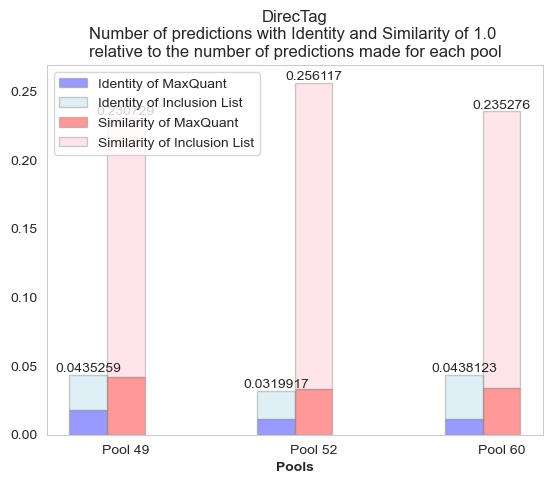

DirecTag :
identity:
 {'MaxQuant': [0.01764565139370738, 0.01131636897479814, 0.011625320959948242], 'InclusionList': [0.025880288710770825, 0.02067531196476633, 0.03218697559693496]}
similarity:
 {'MaxQuant': [0.04201060732942537, 0.03309273305603132, 0.03426942439497786], 'InclusionList': [0.18871874626151453, 0.22302422314656228, 0.201006853884879]}




In [71]:
for alg in algorithms:
    absolute_dict = []
    relative_dict = []
    # create grouped bar plot
    fig, ax = plt.subplots()
    plt.grid()
    barWidth = 0.2
    similarity_100_dict = {
        'MaxQuant': [],
        'InclusionList': []
    }
    identity_100_dict = {
        'MaxQuant': [],
        'InclusionList': []
    }

    for i, p in enumerate(pools):
        experiment_df = experiment_data_dict[p][alg]
        parsed_df = parsed_data_dict[p][alg]
        scored_df = scored_data_dict[p][alg]
        # create bar plot

        total = experiment_df.shape[0]
        identified_maxquant = experiment_df.query('Identified == \'+\'').shape[0]
        predicted = parsed_df.shape[0] if alg != 'DirecTag' else parsed_df['ID'].nunique()
        identified_alg = scored_df.shape[0]

        #similarity_100_dict[p] = scored_df.query('Similarity == 1.0').shape[0]/predicted
        sim_100_mq = scored_df.query('Similarity == 1.0').query('by == \'MaxQuant\'').shape[0]/total
        sim_100_il = scored_df.query('Similarity == 1.0').query('by == \'InclusionList\'').shape[0]/total
        similarity_100_dict['MaxQuant'].append(sim_100_mq)
        similarity_100_dict['InclusionList'].append(sim_100_il)
        #identity_100_dict[p] = scored_df.query('Identity == 1.0').shape[0]/predicted
        id_100_mq = scored_df.query('Identity == 1.0').query('by == \'MaxQuant\'').shape[0]/total
        id_100_il = scored_df.query('Identity == 1.0').query('by == \'InclusionList\'').shape[0]/total
        identity_100_dict['MaxQuant'].append(id_100_mq)
        identity_100_dict['InclusionList'].append(id_100_il)


    # # create bar plot
    plt.title(f'{alg}\nNumber of predictions with Identity and Similarity of 1.0 \nrelative to the number of predictions made for each pool')
    barWidth = 0.2
    r1 = range(len(identity_100_dict['MaxQuant']))
    r2 = [x + barWidth for x in r1]
    plt.bar(r1, identity_100_dict['MaxQuant'], color='b', width=barWidth, edgecolor='grey', label='Identity of MaxQuant', alpha=0.4, bottom=0)
    plt.bar_label(plt.bar(r1, identity_100_dict['InclusionList'], color='lightblue', width=barWidth, edgecolor='grey', label='Identity of Inclusion List', alpha=0.4, bottom=identity_100_dict['MaxQuant']))
    plt.bar(r2, similarity_100_dict['MaxQuant'], color='r', width=barWidth, edgecolor='grey', label='Similarity of MaxQuant', alpha=0.4, bottom=0)
    plt.bar_label(plt.bar(r2, similarity_100_dict['InclusionList'], color='pink', width=barWidth, edgecolor='grey', label='Similarity of Inclusion List', alpha=0.4, bottom=similarity_100_dict['MaxQuant']))
    plt.xlabel('Pools', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(identity_100_dict['MaxQuant']))], [' '.join(x.split('_')) for x in pools])
    plt.legend()
    #plt.savefig(f'{RESULT_DIR}{alg}/perfect_pred_compared_to_nr_of_pred.png')
    plt.show()
    print(alg, ':')
    print("identity:\n",identity_100_dict)
    print("similarity:\n",similarity_100_dict)
    print('\n')

